In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
import csv
import pandas as pd

In [2]:
TRAIN_DIR = '../data/train_img'
TEST_DIR = '../data/test_img'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'hedl-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match


In [3]:
def label_img(img,meta):
    #meta.loc[meta['image_id']==img,'label'].values[0]
    x = meta.loc[meta['image_id']==img,'label'].values[0]
    dis = meta['label'].unique().tolist()
    label = [0 for i in range(len(dis))]
    label[dis.index(x)] = 1
    return label

In [44]:
train_meta = pd.read_csv('../data/train.csv')
train_meta.loc[train_meta['image_id']=='train_1b']['label']
meta = pd.read_csv('../data/train.csv')
print(meta['label'].unique().tolist())
label = label_img('train_1d',meta)
print(str(label))

['rice', 'candy', 'jam', 'coffee', 'vinegar', 'chocolate', 'sugar', 'water', 'juice', 'milk', 'soda', 'nuts', 'chips', 'spices', 'cereal', 'beans', 'cake', 'honey', 'flour', 'pasta', 'tomatosauce', 'tea', 'corn', 'oil', 'fish']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        meta = pd.read_csv('./data/train.csv')
        label = label_img(img.split('.')[0],meta)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data


In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
#create_train_data()
#train_data = create_train_data()
train_data = np.load('train_data.npy')
len(train_data)

3215

In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 25, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [10]:
train = train_data[:-215]
test = train_data[-215:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = np.array([i[1] for i in train])

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]
Y.shape

(3000, 25)

In [15]:
model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}),snapshot_step=50000, show_metric=True, run_id=MODEL_NAME)


Training Step: 93  | total loss: 3.16613 | time: 0.784s
| Adam | epoch: 002 | loss: 3.16613 - acc: 0.0671 -- iter: 2944/3000
Training Step: 94  | total loss: 3.16469 | time: 1.805s
| Adam | epoch: 002 | loss: 3.16469 - acc: 0.0713 | val_loss: 3.15918 - val_acc: 0.0558 -- iter: 3000/3000
--


In [16]:
import tensorflow as tf
tf.reset_default_graph()

In [17]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 25, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')


In [30]:

train = train_data[:-215]
test = train_data[-215:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = np.array([i[1] for i in train])

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 2584  | total loss: 0.59738 | time: 0.784s
| Adam | epoch: 055 | loss: 0.59738 - acc: 0.8144 -- iter: 2944/3000
Training Step: 2585  | total loss: 0.61269 | time: 1.805s
| Adam | epoch: 055 | loss: 0.61269 - acc: 0.8048 | val_loss: 7.73653 - val_acc: 0.1070 -- iter: 3000/3000
--


In [31]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/korde/Documents/HE-DL/inventoryclassifier/src/hedl-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


['rice', 'candy', 'jam', 'coffee', 'vinegar', 'chocolate', 'sugar', 'water', 'juice', 'milk', 'soda', 'nuts', 'chips', 'spices', 'cereal', 'beans', 'cake', 'honey', 'flour', 'pasta', 'tomatosauce', 'tea', 'corn', 'oil', 'fish']














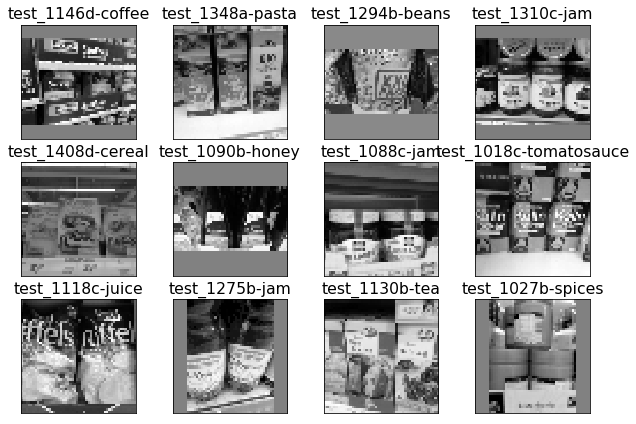

In [60]:
import matplotlib.pyplot as plt
#from matplotlib import style
plt.style.use('seaborn-talk')
# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()
print(meta['label'].unique().tolist())
for num,data in enumerate(test_data[-12:]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    print()
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    #print(model_out)
    for _ in range(0):
        model_out[np.argmax(model_out)]=0
    str_label = img_num+'-'+meta['label'].unique().tolist()[np.argmax(model_out)]
    #str_label=model_out    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()